# Imports

In [15]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as ac

from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,max_iter=500,
                    hidden_layer_sizes=(16, 10,6), random_state=1)

tic=yf.Ticker('GOOG')
df=tic.history('max',interval='1d')

df=df.reset_index()
df=df.drop(['Date','Dividends','Stock Splits'],axis=1)

# Indicators & Neuron prepping

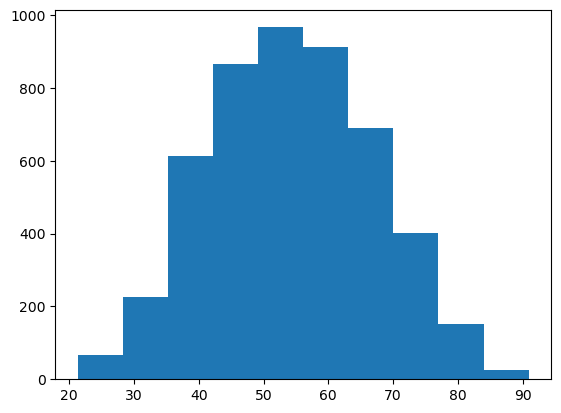

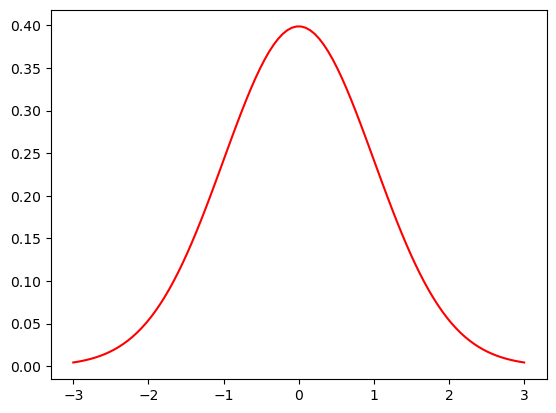

,Open,High,Low,Close,Volume,RSI,Rsi Z-score,RSI d-quark,RSI u-quark,RSI lite-quark
0,2.490664,2.591785,2.390042,2.499133,897427216,NaN,NaN,NaN,NaN,NaN
1,2.515820,2.716817,2.503118,2.697639,458857488,NaN,NaN,NaN,NaN,NaN
2,2.758411,2.826406,2.716070,2.724787,366857939,NaN,NaN,NaN,NaN,NaN
3,2.770615,2.779581,2.579581,2.611960,306396159,NaN,NaN,NaN,NaN,NaN
4,2.614201,2.689918,2.587302,2.640104,184645512,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4928,148.979996,149.619995,147.009995,147.919998,17748400,60.949348,-0.526563,0.0,0.0,0.0
4929,148.789993,149.759995,147.664993,149.679993,17730000,63.259082,-0.710441,0.0,0.0,0.0
4930,150.320007,151.304993,148.009995,148.740005,19843900,61.177837,-0.544753,0.0,0.0,0.0
4931,150.240005,152.559998,150.089996,151.770004,19226300,65.157241,-0.861552,0.0,0.0,0.0


In [16]:
##Relative Streingth Index

df['RSI']=ta.momentum.rsi(df['Close'])

plt.hist(df['RSI'])
plt.show()

x = np.linspace(-3, 3, 100)

plt.plot(x, norm.pdf(x), color='red')
plt.show()


df['Rsi Z-score']=(df['RSI'].mean()-df['RSI'])/df['RSI'].std()

#neurons for neural algo
##down-quark:
df.loc[df['Rsi Z-score']<-1.5,'RSI d-quark']=1
df.loc[df['Rsi Z-score']>-1.5,'RSI d-quark']=0
##up-quark:
df.loc[df['Rsi Z-score']>1.5,'RSI u-quark']=1
df.loc[df['Rsi Z-score']<1.5,'RSI u-quark']=0

#lite signals for weaker signals
##lite-quark
df.loc[df['Rsi Z-score']>=0,'RSI lite-quark']=1
df.loc[df['Rsi Z-score']<=0,'RSI lite-quark']=0
df

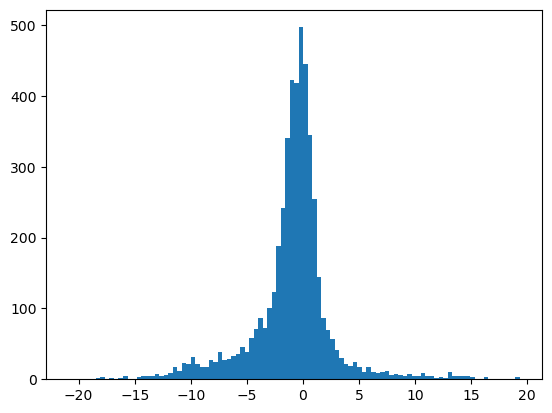

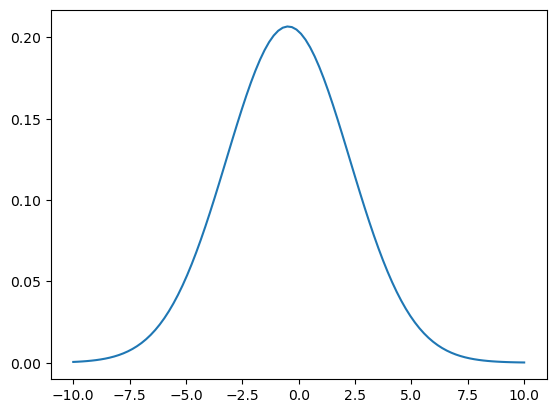

In [17]:
#this is a non-functional module for VWAP quarks

#Volume Weighted average(s)

#VWAP30
df['VWAP30']=(df['Close']*df['Volume']).rolling(30).sum()/df['Volume'].rolling(30).sum()

#VWAP60
df['VWAP60']=(df['Close']*df['Volume']).rolling(60).sum()/df['Volume'].rolling(60).sum()

df['VWAP30 Spread']=df['VWAP30']-df['Close']
df['VWAP60 Spread']=df['VWAP60']-df['Close']

#Z-scores
df['VWAP30 Z']=(df['VWAP30 Spread']-df['VWAP30 Spread'].mean())/df['VWAP30 Spread'].std()
df['VWAP60 Z']=(df['VWAP60 Spread']-df['VWAP60 Spread'].mean())/df['VWAP60 Spread'].std()



##Quarks:

df.loc[df['VWAP30 Z']<=3,'VWAP30 u-quark']=1
df.loc[df['VWAP30 Z']>3,'VWAP30 u-quark']=1
df.loc[df['VWAP30 Z']<=3,'VWAP30 d-quark']=1
df.loc[df['VWAP30 Z']>-3,'VWAP30 d-quark']=1

df.loc[df['VWAP30 Z']<=1.5,'VWAP30 lite-quark']=1
df.loc[df['VWAP30 Z']>-1.5,'VWAP30 lite-quark']=1

df.loc[df['VWAP60 Z']<=3,'VWAP60 u-quark']=1
df.loc[df['VWAP60 Z']>3,'VWAP60 u-quark']=1
df.loc[df['VWAP60 Z']<=-3,'VWAP60 d-quark']=1
df.loc[df['VWAP60 Z']>-3,'VWAP60 d-quark']=1

df.loc[df['VWAP60 Z']<=1.5,'VWAP60 lite-quark']=1
df.loc[df['VWAP60 Z']>-1.5,'VWAP60 lite-quark']=1



df=df.dropna()

plt.hist(df['VWAP60 Spread'],bins=100)
plt.show()

x = np.linspace(-10, 10, 100)
def pdf(x,u,sigma):
    f=np.exp(-1/2*((x-u)/sigma)**2)/(sigma*np.sqrt(np.pi))
    return f
    
plt.plot(x,pdf(x,df['VWAP30 Spread'].mean(),df['VWAP30 Spread'].std()))


##quark:
#df.loc[df['WVAP30 Spread']<=0,'WVAP30 quark']=1
#df.loc[df['WVAP30 Spread']>0,'WVAP30 quark']=0

In [18]:
df=df.dropna()

df.loc[df['Close'].pct_change()<0,'Target']=1
df.loc[df['Close'].pct_change()>0,'Target']=0

df=df.dropna()
X=df.drop(['Open','High','Low','Close','Volume','RSI','Rsi Z-score','Target','VWAP30 Spread','VWAP30','VWAP60','VWAP60 Spread','VWAP30 Z','VWAP60 Z'],axis=1)
Y=df['Target']
Y=Y.dropna()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

clf.fit(X_train,Y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(16, 10, 6), max_iter=500,
              random_state=1, solver='lbfgs')

In [19]:
print("Accuracy of the model is based on test sample is:",clf.score(X_test, Y_test))
print("Accuracy of the model is based on test whole array is:",clf.score(X, Y))

Accuracy of the model is based on test sample is: 0.6311475409836066
Accuracy of the model is based on test whole array is: 0.6036535303776683
